In [27]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
folder_path = "../RA_data"

df_list = []

# Iterate through all CSV files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".csv"):  # Check if the file is a CSV
        file_path = os.path.join(folder_path, file)
        print(f"Reading: {file}")
        try:
            df_individual = pd.read_csv(file_path, on_bad_lines='skip')
            if 'Peoria' in df_individual['cities'][0]:
                df_individual['city_type'] = 'US'
            else: df_individual['city_type'] = 'Fictional'
            df_list.append(df_individual)
        except Exception as e:
            print(f"Error reading {file}: {e}")

# Concatenate all DataFrames
df_flights = pd.concat(df_list, ignore_index=True)
df_flights['partid'] = df_flights['responses'].str.replace('{worker_id:',"").str.replace('}', '')
df_flights['partid'] = df_flights['partid'].ffill()
df_flights['sequence']=df_flights['sequence'].ffill()
df_flights

Reading: final_S_3075.csv
Reading: S_3024_1430_718.csv
Reading: S_3007_1316_633.csv


,rt,responses,trial_type,time_elapsed,sequence,stimulus,cities,city_images,button_pressed,response,...,problems,smooth,distraction,strategies,easier,similar,comments,detectfocus,city_type,partid
0,225697.4,{worker_id:3075},id_enter,225698,blocked,intro,Hawthorne Bluffs; Hollendale; Sunmere; North A...,US_Cities_List/gong.png; US_Cities_List/jukebo...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fictional,3075
1,1972.2,NaN,fullscreen,227676,blocked,make_fullscreen,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fictional,3075
2,8038.2,NaN,intro_1,235717,blocked,instruct,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fictional,3075
3,15004.0,NaN,intro_2,250724,blocked,instruct,NaN,NaN,1.0,Next,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fictional,3075
4,18620.0,NaN,intro_3,269346,blocked,instruct,NaN,NaN,1.0,Next,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fictional,3075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2882,1105.6,NaN,intro_5,1594961,blocked,instruct,NaN,NaN,1.0,Next,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,3007
2883,13505.5,NaN,intro_6,1608470,blocked,instruct,NaN,NaN,1.0,Next,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,3007
2884,NaN,NaN,Goal Directed Planning,1804107,blocked,GDP-0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,3007
2885,NaN,NaN,Goal Directed Planning,1903204,blocked,GDP-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,3007


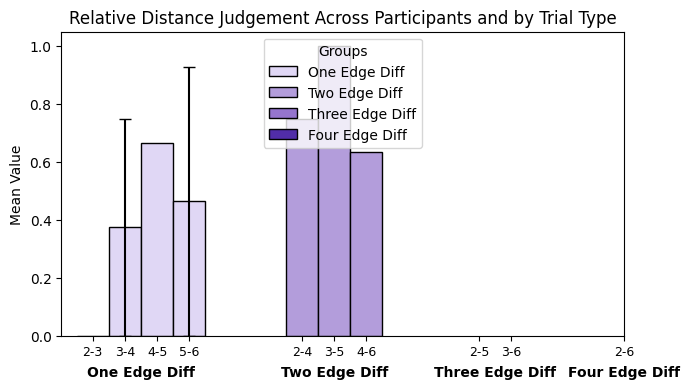

In [5]:
bad_partid = ['5cba50bf114fa5001aac5570','6657584ca6e3645f4a99e753','67e2b86a96de1816df85cefe','5fadeb340e10471fdeb5fbf5']
direct_df = df_flights[df_flights['trial_type']=='directmemory_phase']
direct_df = direct_df.loc[:, ~direct_df.isna().all()]
direct_df = direct_df.drop(columns=['time_elapsed','cumulative_accuracy','weighted_accuracy','missedtrial']).reset_index(drop='index')
direct_df = direct_df.map(lambda x: x.replace('../static/images/US_Cities_List/', '') if isinstance(x, str) else x)
direct_df = direct_df.map(lambda x: x.replace('../static/images/Fictional_Cities_List/', '') if isinstance(x, str) else x)
direct_df = direct_df.map(lambda x: x.replace('../static/images/GW/', '') if isinstance(x, str) else x)

shortest_df = df_flights[df_flights['trial_type']=='shortestpath_phase']
shortest_df = shortest_df.loc[:, ~shortest_df.isna().all()]
shortest_df = shortest_df.drop(columns=['time_elapsed','cumulative_accuracy']).reset_index(drop='index')
shortest_df = shortest_df.map(lambda x: x.replace('../static/images/US_Cities_List/', '') if isinstance(x, str) else x)
shortest_df = shortest_df.map(lambda x: x.replace('../static/images/Fictional_Cities_List/', '') if isinstance(x, str) else x)
shortest_df = shortest_df.map(lambda x: x.replace('../static/images/GW/', '') if isinstance(x, str) else x)

# Step 1: Combine stimulus and stimulus_correct into one long-form df with accuracy
long_direct_df = pd.concat([
    direct_df[['partid', 'stimulus', 'accuracy']].rename(columns={'stimulus': 'city'}),
    direct_df[['partid', 'stimulus_correct', 'accuracy']].rename(columns={'stimulus_correct': 'city'})
])

# Step 2: Group by participant and city, then check if all accuracies were 1.0
city_accuracy = long_direct_df.groupby(['partid', 'city'])['accuracy'].agg(lambda x: (x == 1.0).all()).reset_index()
city_accuracy = city_accuracy[city_accuracy['accuracy']]  # Keep only 100% accurate cities
city_accuracy = city_accuracy.drop(columns='accuracy')     # Just keep partid and city

# Step 3: Filter shortest_df by keeping only rows where both cities were 100% accurate
filtered_shortest_df = shortest_df[
    shortest_df.apply(
        lambda row: (
            (row['partid'], row['stimulus']) in city_accuracy.set_index(['partid', 'city']).index and
            (row['partid'], row['stimulus_correct']) in city_accuracy.set_index(['partid', 'city']).index
        ),
        axis=1
    )
]
grouped_shortest = filtered_shortest_df.groupby(['partid','specific_pairs'])['accuracy'].agg(['mean','count']).reset_index()

twothree = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Three Edge']
threefour = grouped_shortest[grouped_shortest['specific_pairs']=='Three Edge Four Edge']
fourfive = grouped_shortest[grouped_shortest['specific_pairs']=='Four Edge Five Edge']
fivesix = grouped_shortest[grouped_shortest['specific_pairs']=='Five Edge Six Edge']

twofour = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Four Edge']
threefive = grouped_shortest[grouped_shortest['specific_pairs']=='Three Edge Five Edge']
foursix = grouped_shortest[grouped_shortest['specific_pairs']=='Four Edge Six Edge']

twofive = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Five Edge']
threesix = grouped_shortest[grouped_shortest['specific_pairs']=='Three Edge Six Edge']

twosix = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Six Edge']

# --- Sample Data ---
group_labels = ['One Edge Diff', 'Two Edge Diff', 'Three Edge Diff', 'Four Edge Diff']

# Generate dummy data
heights = [
    [twothree['mean'].mean(), threefour['mean'].mean(), fourfive['mean'].mean(), fivesix['mean'].mean()],  # One diff
    [twofour['mean'].mean(), threefive['mean'].mean(), foursix['mean'].mean()],       # Two diff
    [twofive['mean'].mean(), threesix['mean'].mean()],            # Three diff
    [twosix['mean'].mean()]                  # Four diff
]

errors = [
    [twothree['mean'].sem(), threefour['mean'].sem(), fourfive['mean'].sem(), fivesix['mean'].sem()],  # One diff
    [twofour['mean'].sem(), threefive['mean'].sem(), foursix['mean'].sem()],       # Two diff
    [twofive['mean'].sem(), threesix['mean'].sem()],            # Three diff
    [twosix['mean'].sem()]                  # Four diff
]

bar_labels = [
    ['2-3', '3-4', '4-5', '5-6'],     # One diff
    ['2-4', '3-5', '4-6'],          # Two diff
    ['2-5', '3-6'],               # Three diff
    ['2-6']                    # Four diff
]

bar_width = 0.2
group_gap = 0.5

fig, ax = plt.subplots(figsize=(7, 4))

x_offset = 0
all_positions = []
all_labels = []
group_centers = []
# Optional: participant-level means
participant_means = shortest_df.groupby(['partid', 'specific_pairs'])['accuracy'].mean().reset_index()

# Then Tukey test on those
# tukey = pairwise_tukeyhsd(endog=participant_means['accuracy'],
#                         groups=participant_means['specific_pairs'],
#                         alpha=0.05)
# print(tukey.summary())
# Define blue color shades (lightest to darkest)
group_colors = ['#e0d7f5', '#b39ddb', '#9575cd', '#512da8']
# group_colors = ['#cce5ff', '#66b3ff', '#1f78b4', '#08306b']  # Adjust or expand as needed

for i, (group, group_err, labels) in enumerate(zip(heights, errors, bar_labels)):
    num_bars = len(group)
    positions = np.arange(num_bars) * bar_width + x_offset
    ax.bar(positions, group, yerr=group_err, capsize=4, width=bar_width,
        edgecolor='black', label=group_labels[i], color=group_colors[i])
    
    # Store positions and labels for x-ticks
    all_positions.extend(positions)
    all_labels.extend(labels)
    
    # Calculate center of group for big group label
    group_centers.append(positions.mean())
    
    # Update x offset for next group
    x_offset = positions[-1] + bar_width + group_gap

# Set small bar labels as x-tick labels
ax.set_xticks(all_positions)
ax.set_xticklabels(all_labels, fontsize=9)

# Add big group labels below
for center, label in zip(group_centers, group_labels):
    ax.text(center, -0.1, label, ha='center', va='top', fontsize=10,
            fontweight='bold', transform=ax.transData)
# --- Formatting ---
ax.legend(title='Groups')
ax.set_ylabel('Mean Value')
ax.set_title(f'Relative Distance Judgement Across Participants and by Trial Type')
plt.tight_layout()
plt.show()

UnboundLocalError: cannot access local variable 'group_colors' where it is not associated with a value

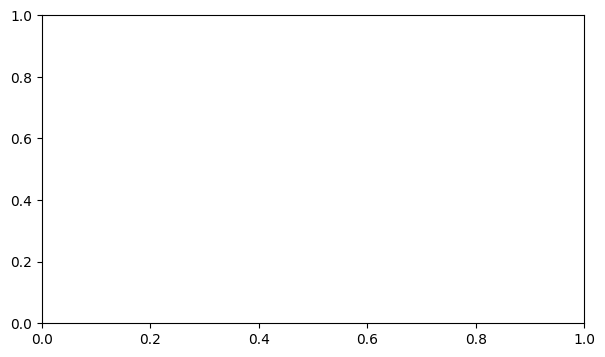

In [18]:
df_flights['condition'].unique()

array([nan, 'One Edge Diff', 'Two Edge Diff', '1'], dtype=object)

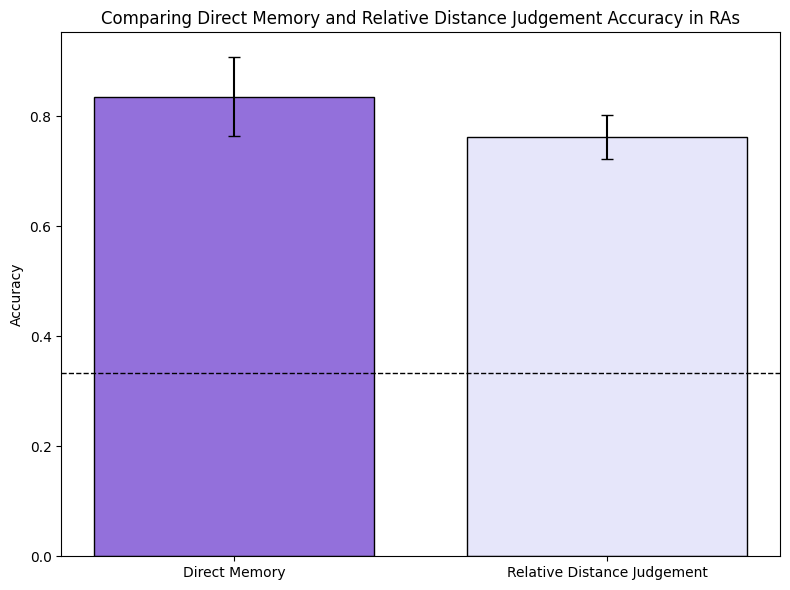

In [55]:
from matplotlib.patches import Patch
def get_chosen_city(row):
    if  row['key_press'] == 49:
        return row['stimulus_down_left']
    elif  row['key_press'] == 50:
        return row['stimulus_down_mid']
    elif  row['key_press'] == 51:
        return row['stimulus_down_right']
    else: return pd.NA

def get_wrong_distance(row):
    if pd.isna(row['stimulus_selected']):
        return pd.NA
    elif row['stimulus_selected'] == row['stimulus_short']:
        return 'close'
    elif row['stimulus_selected'] == row['stimulus_far']:
        return 'far'
    elif row['stimulus_selected'] == row['stimulus_correct']:
        return 'correct'
    else: return pd.NA

def get_weighted_correct(row):
    if pd.isna(row['wrong_distance']):
        return pd.NA
    elif row['wrong_distance'] == 'close':
        return 0.5
    elif row['wrong_distance'] == 'far':
        return 0
    elif row['wrong_distance'] == 'correct':
        return 1
    else: return pd.NA

df_flights = df_flights[~df_flights['stimulus'].isna()]
direct_df_flights = df_flights[df_flights['trial_type']=='directmemory_phase']
direct_df_flights = direct_df_flights.loc[:, ~direct_df_flights.isna().all()]
direct_df_flights = direct_df_flights.drop(columns=['time_elapsed','cumulative_accuracy','weighted_accuracy','missedtrial']).reset_index(drop='index')
direct_df_flights = direct_df_flights.map(lambda x: x.replace('../static/images/US_Cities_List/', '') if isinstance(x, str) else x)
direct_df_flights = direct_df_flights.map(lambda x: x.replace('../static/images/Fictional_Cities_List/', '') if isinstance(x, str) else x)
direct_df_flights = direct_df_flights.map(lambda x: x.replace('../static/images/GW/', '') if isinstance(x, str) else x)

# for id in bad_partid:
#     direct_df = direct_df[direct_df['partid'] != id]

direct_df_flights['stimulus_selected'] = direct_df_flights.apply(get_chosen_city,axis=1)
direct_df_flights['wrong_distance'] = direct_df_flights.apply(get_wrong_distance,axis=1)
direct_df_flights['weighted_correct'] = direct_df_flights.apply(get_weighted_correct,axis=1)
direct_df_flights = direct_df_flights[(direct_df_flights['rt']>400)&(direct_df_flights['rt']<5000)]

direct_young1 = direct_df_flights.groupby('partid')['accuracy'].mean()
direct_young1

df_short = df_flights[(df_flights['trial_type']=='shortestpath_phase') & df_flights['stimulus'].notna() & (df_flights['rt'] > 400) & (df_flights['rt'] < 5000)]
df_short1 = df_short.groupby('partid')['accuracy'].mean()
plt.figure(figsize=(8,6))
plt.bar(x=0.3,height= direct_young1.mean(),yerr=direct_young1.sem(),capsize=4,color='mediumpurple',width=0.3,edgecolor='black',label='Direct Memory')
plt.bar(x=.7,height= df_short1.mean(),yerr=df_short1.sem(),capsize=4,color='lavender',width=0.3,edgecolor='black',label='Relative Distance Judgement')

plt.axhline(y=0.3333, color='black', linestyle='--', linewidth=1)
plt.xticks([0.3,.7],['Direct Memory','Relative Distance Judgement'])
plt.ylabel( "Accuracy")
plt.title(f"Comparing Direct Memory and Relative Distance Judgement Accuracy in RAs")
plt.grid(False)
plt.tight_layout()
plt.show()


In [56]:
df_short1

partid
3007    0.815385
3024    0.787500
3075    0.684211
Name: accuracy, dtype: float64